<a href="https://colab.research.google.com/github/Bensmail-anis/Autoregressive-Character-Level-Language-Modeling/blob/main/notebooks/Wavenet_Architecture_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolving from MLPs to Hierarchical Neural Architectures


Our previous notebooks explored traditional Multilayer Perceptrons (MLPs), which processed sequences with a fixed, uniform approach. These models, while powerful, had limitations in capturing long-range dependencies and contextual nuances, especially in tasks like character-level language modeling.

The breakthrough came in 2016 with DeepMind's WaveNet paper, a revolutionary architecture that fundamentally reimagined sequence processing. Originally developed for text-to-speech and audio generation, WaveNet introduced a hierarchical convolutional approach that dramatically expanded a model's ability to understand and generate sequences. Instead of treating all context equally, WaveNet proposed a progressive, exponential receptive field expansion - a concept that allows neural networks to capture increasingly complex, long-range dependencies.


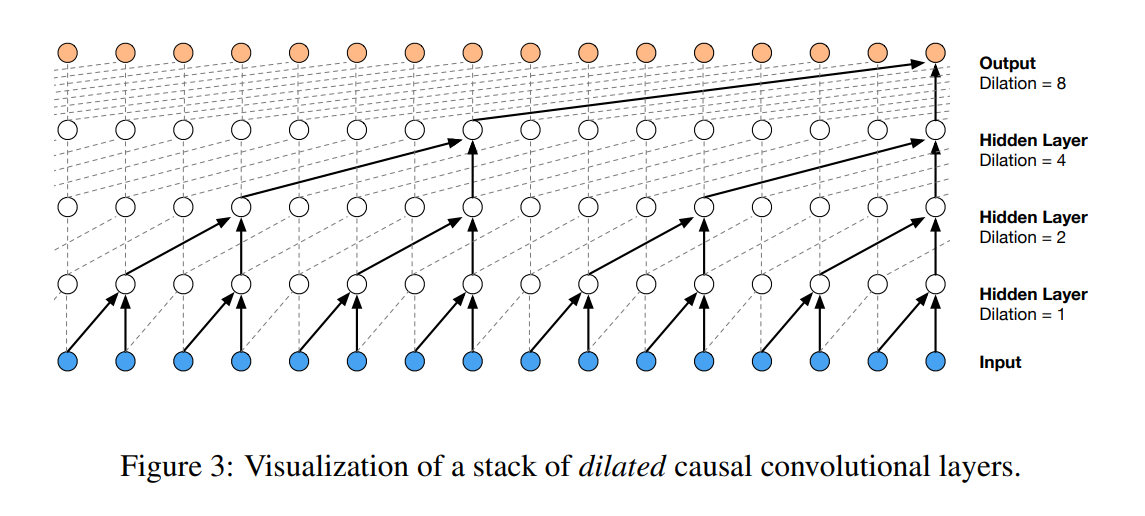
Our current implementation is a direct intellectual descendant of those ideas, adapted for character-level name generation. By introducing the FlattenConsecutive layer and a carefully designed hierarchical architecture, we're essentially creating a lightweight neural network that can learn intricate patterns of character sequences. Unlike traditional MLPs that process a fixed window of characters uniformly, our model progressively builds context: first looking at adjacent characters, then pairs of those pairs, then groups of four, and so on.


The magic lies in how this architecture mimics human pattern recognition. When we learn a language or recognize names, we don't just look at immediate neighbors; we simultaneously consider micro and macro contextual cues. Our hierarchical model does precisely that - it creates a neural network that can simultaneously understand local character transitions and broader naming patterns.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Data Preparation

as we did before , we begins with understanding and preparing the raw data.

Vocabulary creation is the next critical phase. we generates a comprehensive character set by collecting all unique characters across all names. This is done through a clever set comprehension that joins all words and extracts unique characters. The characters are then sorted, creating a deterministic mapping. Two key dictionaries are created: stoi (string to integer) and itos (integer to string) mappings. These dictionaries are fundamental to converting text into numerical input that neural networks can process. A special '.' character is added with index 0, which likely serves as an end-of-word marker.

The data preparation concludes with dataset splitting.The words are shuffled to prevent any sequential bias. The dataset is divided into three subsets: training (80%), validation (10%), and testing (10%).

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Layers blocks - Introducing FlattenConsecutive

For ecucational purposes , we implemented the layers manually to not use the built in class in pytorch .

The FlattenConsecutive layer is the innovation of this step . Traditional neural networks process sequences uniformly, but this layer introduces a hierarchical approach inspired by wavenet architectures.

By consecutively merging groups of elements, it creates a progressive receptive field expansion. For instance, with n=2, a sequence of 8 characters first becomes 4 groups of 2, effectively doubling the feature depth while halving the temporal dimension.

Think of FlattenConsecutive as a dynamic feature extractor that allows the network to capture increasingly complex patterns.

 In the first layer, it might merge adjacent characters, in the next layer, it merges groups of 4, and so on. This approach mimics how humans recognize patterns - first looking at immediate context, then progressively expanding the perspective. The layer's implementation is elegant: it reshapes the input tensor, maintaining batch and feature dimensions while reorganizing the temporal dimension.

we make use of .view method to reshape tensors for each step  [torch.Tensor.view documentation](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)

In [7]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n
# method __call__ is called when an instance of FlattenConsecutive is invoked like a function.
# It reshapes the input tensor by merging n timesteps. If the reshaped tensor's sequence length becomes 1, it removes that redundant dimension to avoid unnecessary computational complexity.
# The new shape is (B, T//n, C*n) where T//n represents the reduced sequence length,
# and C*n represents the merged features for each grouped timestep.

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [8]:
torch.manual_seed(42); # seed rng for reproducibility

## Dimensionality in Batch Normalization: A Flexible Approach
==========================================================

The Motivation for Multi-Dimensional Support
--------------------------------------------

Batch Normalization (BatchNorm) is typically used in various neural network architectures that process data with different tensor shapes. In deep learning, you'll encounter tensors with different numbers of dimensions:

1.  **2D Tensors**: Typical in standard fully connected layers
    
    *   Shape: \[Batch, Features\]
        
    *   Example: \[32, 128\] (32 samples, 128 features)
        
2.  **3D Tensors**: Common in sequential or convolutional layers
    
    *   Shape: \[Batch, Sequence, Features\]
        
    *   Example: \[32, 8, 128\] (32 samples, 8 time steps, 128 features)
        

Breaking Down the Conditional Dimension Selection
-------------------------------------------------

```python
if x.ndim == 2:
    dim = 0
elif x.ndim == 3:
    dim = (0,1)  
```
### 2D Case (Fully Connected Layers)

*   When x.ndim == 2, it means we're dealing with a standard fully connected layer
    
*   dim = 0 means we normalize across the batch dimension
    
*   Each feature column is normalized independently
    
*   Calculation: Mean and variance computed across all samples for each feature
    

### 3D Case (Sequential/Hierarchical Layers)

*   When x.ndim == 3, we have a sequential or hierarchical input
    
*   dim = (0,1) means normalization across batch and sequence dimensions
    
*   Preserves the feature representation of each time step
    
*   Allows normalization in more complex architectures like RNNs or our hierarchical name generator
    

Practical Example in Our Name Generator
---------------------------------------

In our hierarchical architecture, we use layers that transform tensor shapes:

*   Embedding creates 3D tensors
    
*   FlattenConsecutive can change tensor dimensions
    
*   BatchNorm needs to handle these transformations seamlessly
    

### Visualization of Normalization

2D Case:

```python
Input: [32, 128]
Normalization computes:
- 128 independent mean values (one per feature)
- 128 independent variance values

```


3D Case:

```python
Input: [32, 8, 128]
Normalization computes:
- Mean across batch and sequence (32 * 8 samples)
- Variance across batch and sequence
- Preserves the 128 feature dimensions

```

Why This Approach Matters
-------------------------

1.  **Architectural Flexibility**
    
    *   Works with various network architectures
        
    *   Supports fully connected, recurrent, and hierarchical models
        
2.  **Computational Efficiency**
    
    *   Compute statistics efficiently across relevant dimensions
        
    *   Prevent overfitting by normalizing appropriately
        
3.  **Generalization**
    
    *   Handle different input shapes without changing the normalization logic
        
    *   Adapt to complex, multi-dimensional neural network designs
        


Starting with character embeddings of 24 dimensions, it progressively expands context and feature representation. The sequence of layers - embedding, flatten, linear transformation, batch normalization, and non-linear activation - creates a powerful feature extraction pipeline. Each stage doubles the contextual understanding: from 2-character context to 4, then to 8, creating a wavenet-like receptive field.
The final linear layer maps these rich, hierarchically extracted features back to the vocabulary space, enabling character prediction. By initializing the final layer's weights with a smaller scale (multiplying by 0.1), the model starts with more conservative predictions, allowing gradual refinement during training. This architectural choice ensures that the model doesn't overfit early and can learn nuanced character-level patterns.

In [9]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


### Understanding Cross-Entropy Loss: The Mathematical Heart of Probabilistic Prediction
Let's dive deep into the cross-entropy loss, which is essentially the negative average log likelihood, and unpack its mathematical and conceptual significance.

====================================================================================

At its core, cross-entropy loss measures the difference between two probability distributions - the true distribution of our data and the predicted distribution from our model. In character-level language modeling, this means comparing the actual next character with our model's predicted probabilities across all possible characters.

Mathematical Breakdown
----------------------

Let's break down the formula step by step:

1.  **Probability Distribution**:
    
    *   Our model outputs logits (raw, unnormalized scores)
        
    *   These are converted to probabilities using softmax
        
    *   Each logit represents the model's confidence for a particular character
        
2.  **Log Likelihood Calculation**:
    
    *   For each training example, we take the logarithm of the probability of the correct character
        
    *   Logarithm transforms multiplication into addition and amplifies small probability differences
        
    *   Taking the negative ensures we're minimizing the loss (lower loss = better prediction)
        

Intuitive Explanation
---------------------

Imagine the model is playing a guessing game:

*   It provides probabilities for the next character
    
*   The true label is like the "correct answer"
    
*   Cross-entropy measures how "surprised" the model is when the true character is revealed
    

### Example Walkthrough

Let's say we're predicting the next character in the name "Anna":

*   Current context: "Ann"
    
*   Possible next characters: a, b, c, ...
    
*   Model predicts probabilities:
    
    *   'a': 0.9
        
    *   'b': 0.05
        
    *   'c': 0.05
        

The loss calculation would:

1.  Take log(0.9)
    
2.  Make it negative
    
3.  This gives a low loss value, indicating a confident correct prediction
    

If the model predicted 'b' with high probability instead, the loss would be much higher.
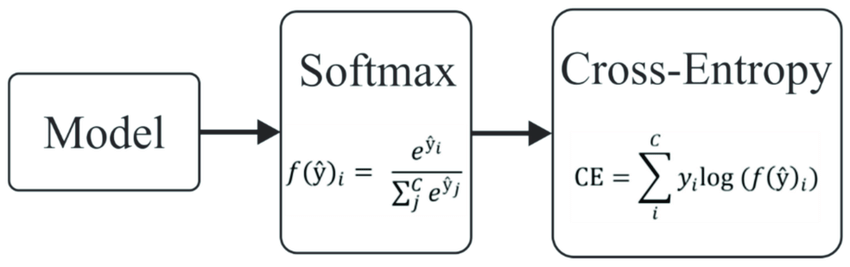

Mathematical Formalization
--------------------------

Cross-Entropy Loss = -Σ(true\_probability \* log(predicted\_probability))

In code, this is elegantly implemented by PyTorch's F.cross\_entropy(), which:

*   Applies softmax
    
*   Calculates negative log likelihood
    
*   Averages across the batch
    

Why Logarithm?
--------------

The logarithm does three magical things:

1.  Transforms multiplicative errors into additive errors
    
2.  Penalizes confident wrong predictions more harshly
    
3.  Makes optimization mathematically nicer
    

### Visualization Mental Model

Think of loss as a "surprise meter":

*   Confident correct predictions → Very low surprise → Low loss
    
*   Confident incorrect predictions → High surprise → High loss
    
*   Uncertain predictions → Moderate surprise → Moderate loss
    

Practical Implications in Our Name Generation Model
---------------------------------------------------

In our character-level model, cross-entropy loss helps the network learn:

*   Which character transitions are most likely
    
*   How to build probabilistic representations of names
    
*   Capture subtle patterns in character sequences
    

The loss guides the model to:

*   Predict common character sequences
    
*   Understand naming conventions
    
*   Generate plausible new names

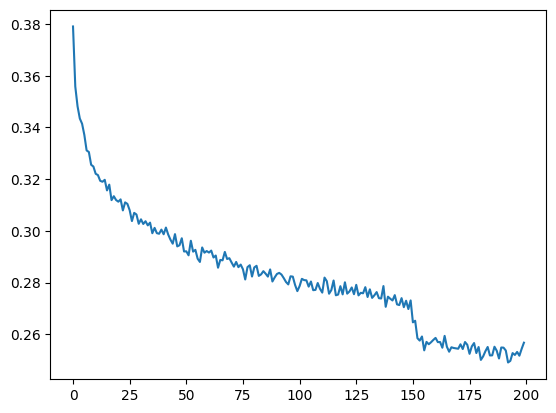

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [12]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [13]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690281867980957
val 1.9936515092849731


In [14]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.
